In [1]:
import json
import plotly.graph_objects as go

from glob import glob

import sys
sys.path.append('../../Data/auxiliary/')

In [2]:
def replace_special_char(string):
    changes = [('á', 'a'), ('à', 'a'), ('â', 'a'), ('ã', 'a'),
               ('é', 'e'), ('ê', 'e'), ('í', 'i'), ('ó', 'o'),
               ('ô', 'o'), ('õ', 'o'), ('ú', 'u'), ('ç', 'c')]
    
    for change in changes: string = string.replace(change[0], change[1])
    return string

In [3]:
cards = dict()
cards_on_classics = dict()
cards_time = [0] * 90
cards_time_on_classics = [0] * 90
goals = dict()
goals_time = [0] * 90
summary = dict()
all_players = dict()
for file in sorted(glob('../../Data/results/processed/Serie_A_*_squads.json')):
    season = int(file[-16:-12])
    if season == 2024: continue
    cards[season] = 0
    goals[season] = 0
    summary[season] = dict()
    all_players[season] = set()
    
    info_file = file.replace('squads', 'games')
    with open(file, 'rb') as f: data = json.load(f)
    with open(info_file, 'rb') as f: info = json.load(f)
    for game in data:
        home_club = info[game]['Home']
        away_club = info[game]['Away']
        
        if home_club not in summary[season]: summary[season][home_club] = set()
        if away_club not in summary[season]: summary[season][away_club] = set()
        
        passed_time = 0
        for sub_game in data[game]:
            cards[season] += len(data[game][sub_game]['Home']['Cards'])
            cards[season] += len(data[game][sub_game]['Away']['Cards'])
            if len(data[game][sub_game]['Home']['Cards']) != 0:
                for card in data[game][sub_game]['Home']['Cards']:
                    minute, player = card
                    minute += passed_time
                    cards_time[minute - 1] += 1
                    if home_club[-2:] == away_club[-2:]:
                        cards_time_on_classics[minute - 1] += 1

            if len(data[game][sub_game]['Away']['Cards']) != 0:
                for card in data[game][sub_game]['Away']['Cards']:
                    minute, player = card
                    minute += passed_time
                    cards_time[minute - 1] += 1
                    if home_club[-2:] == away_club[-2:]:
                        cards_time_on_classics[minute - 1] += 1
            
            goals[season] += len(data[game][sub_game]['Home']['Goals'])
            goals[season] += len(data[game][sub_game]['Away']['Goals'])
            if len(data[game][sub_game]['Home']['Goals']) != 0:
                for goal in data[game][sub_game]['Home']['Goals']:
                    minute, player = goal
                    minute += passed_time
                    goals_time[minute - 1] += 1

            if len(data[game][sub_game]['Away']['Goals']) != 0:
                for goal in data[game][sub_game]['Away']['Goals']:
                    minute, player = goal
                    minute += passed_time
                    goals_time[minute - 1] += 1

            home_squad = data[game][sub_game]['Home']['Squad']
            away_squad = data[game][sub_game]['Away']['Squad']
            
            summary[season][home_club] = summary[season][home_club].union(set(home_squad))
            summary[season][away_club] = summary[season][away_club].union(set(away_squad))
            
            all_players[season] = all_players[season].union(set(home_squad))
            all_players[season] = all_players[season].union(set(away_squad))
            
            passed_time += data[game][sub_game]['Time']

for season in summary:
    all_players[season] = len(all_players[season])
    for club in summary[season]:
        summary[season][club] = len(summary[season][club])
    
    summary[season] = sum(summary[season].values()) / len(summary[season])


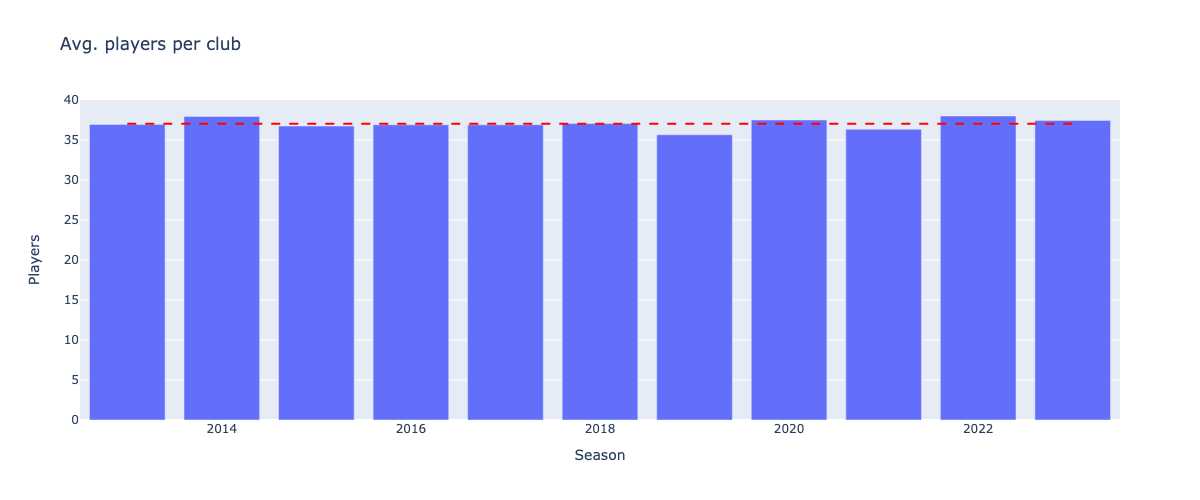

In [4]:
season = list(summary.keys())
value = list(summary.values())
mean = sum(value) / len(value)

fig = go.Figure()
fig.add_trace(go.Bar(x=season, y=value))
fig.add_shape(type='line', x0=season[0], y0=mean, x1=season[-1], y1=mean,
              line=dict(color='red', width=2, dash='dash'))

fig.update_layout(title='Avg. players per club',
                  xaxis_title='Season',
                  yaxis_title='Players',
                  showlegend=False)

fig.write_image('../figures/players_per_club.png')
fig.show('png', width=1200)

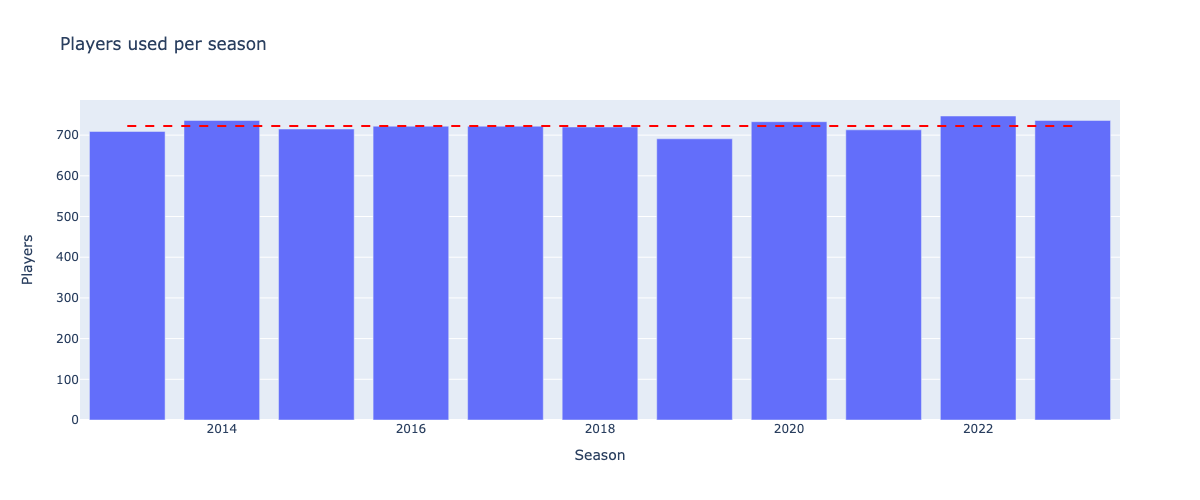

In [5]:
season = list(all_players.keys())
value = list(all_players.values())
mean = sum(value) / len(value)

fig = go.Figure()
fig.add_trace(go.Bar(x=season, y=value))
fig.add_shape(type='line', x0=season[0], y0=mean, x1=season[-1], y1=mean,
              line=dict(color='red', width=2, dash='dash'))

fig.update_layout(title='Players used per season',
                  xaxis_title='Season',
                  yaxis_title='Players',
                  showlegend=False)

fig.write_image('../figures/players_per_season.png')
fig.show('png', width=1200)

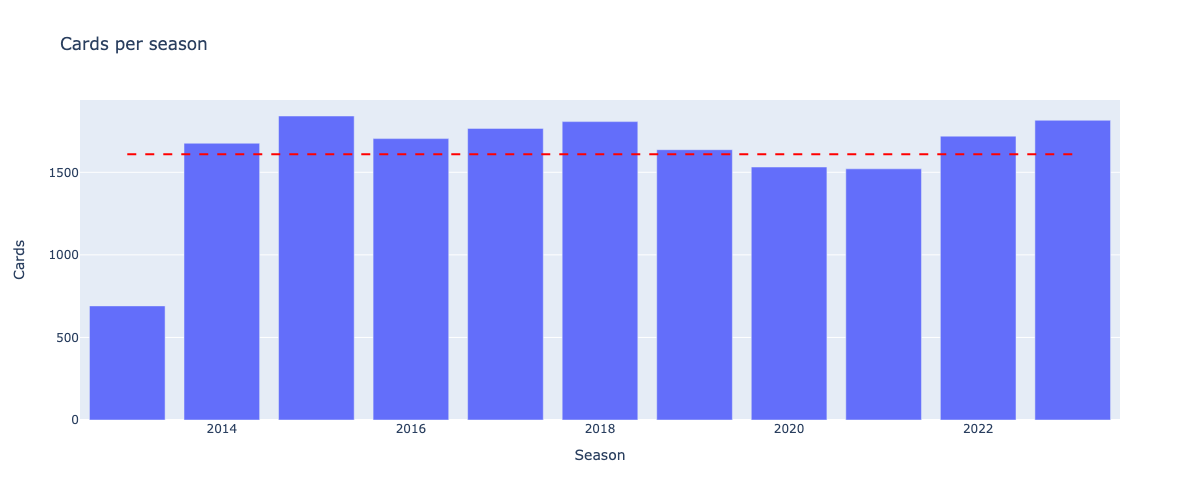

In [6]:
season = list(cards.keys())
value = list(cards.values())
mean = sum(value) / len(value)

fig = go.Figure()
fig.add_trace(go.Bar(x=season, y=value))
fig.add_shape(type='line', x0=season[0], y0=mean, x1=season[-1], y1=mean,
              line=dict(color='red', width=2, dash='dash'))

fig.update_layout(title='Cards per season',
                  xaxis_title='Season',
                  yaxis_title='Cards',
                  showlegend=False)

fig.write_image('../figures/cards_per_season.png')
fig.show('png', width=1200)

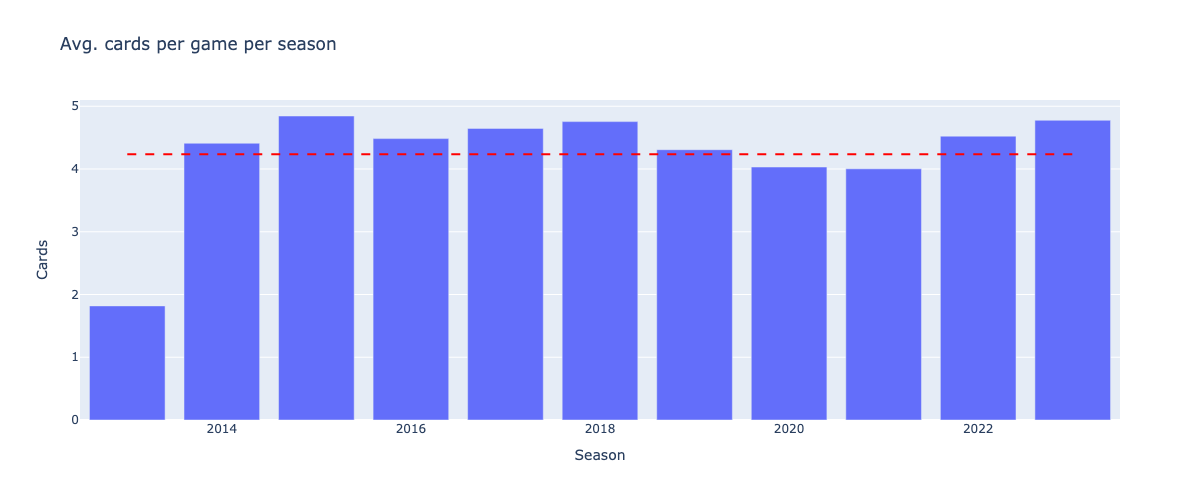

In [7]:
season = list(cards.keys())
value = list(cards.values())
value = [v / 380 for v in value]
mean = sum(value) / len(value)

fig = go.Figure()
fig.add_trace(go.Bar(x=season, y=value))
fig.add_shape(type='line', x0=season[0], y0=mean, x1=season[-1], y1=mean,
              line=dict(color='red', width=2, dash='dash'))

fig.update_layout(title='Avg. cards per game per season',
                  xaxis_title='Season',
                  yaxis_title='Cards',
                  showlegend=False)

fig.write_image('../figures/cards_per_game_per_season.png')
fig.show('png', width=1200)

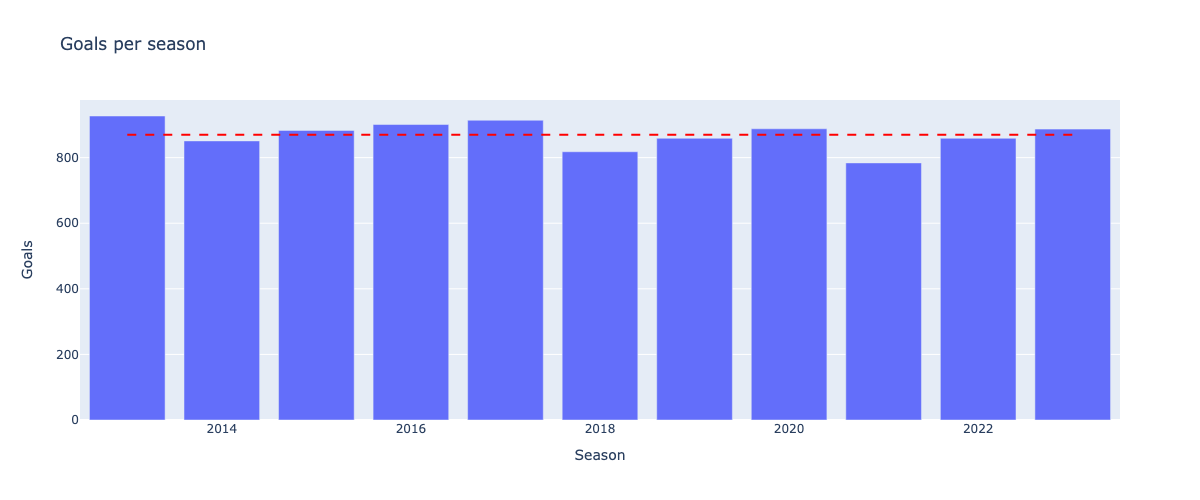

In [8]:
season = list(goals.keys())
value = list(goals.values())
mean = sum(value) / len(value)

fig = go.Figure()
fig.add_trace(go.Bar(x=season, y=value))
fig.add_shape(type='line', x0=season[0], y0=mean, x1=season[-1], y1=mean,
              line=dict(color='red', width=2, dash='dash'))

fig.update_layout(title='Goals per season',
                  xaxis_title='Season',
                  yaxis_title='Goals',
                  showlegend=False)

fig.write_image('../figures/total_goals_per_season.png')
fig.show('png', width=1200)

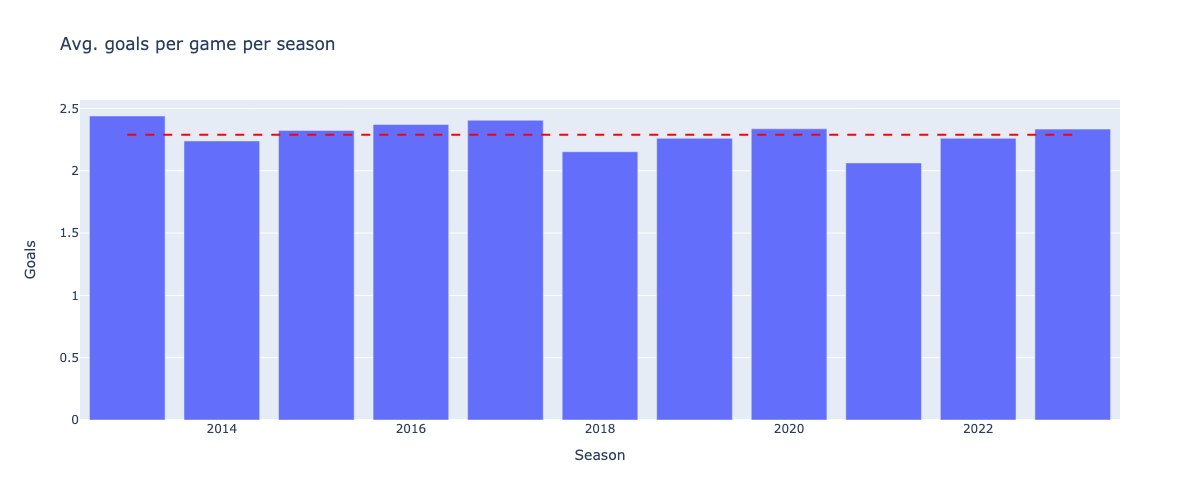

In [9]:
season = list(goals.keys())
value = list(goals.values())
value = [v / 380 for v in value]
mean = sum(value) / len(value)

fig = go.Figure()
fig.add_trace(go.Bar(x=season, y=value))
fig.add_shape(type='line', x0=season[0], y0=mean, x1=season[-1], y1=mean,
              line=dict(color='red', width=2, dash='dash'))

fig.update_layout(title='Avg. goals per game per season',
                  xaxis_title='Season',
                  yaxis_title='Goals',
                  showlegend=False)

fig.write_image('../figures/goals_per_game_per_season.png')
fig.show('png', width=1200)

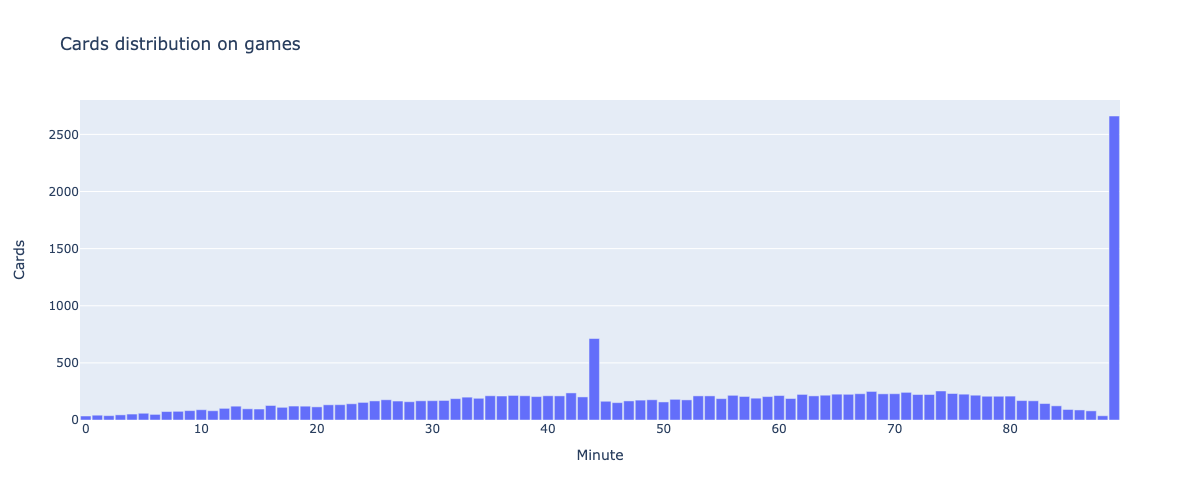

In [10]:
fig = go.Figure(data=[go.Bar(x=list(range(len(cards_time))), y=cards_time)])
fig.update_layout(
    title='Cards distribution on games',
    xaxis_title='Minute',
    yaxis_title='Cards',
    bargap=0.1
)

fig.show('png', width=1200)

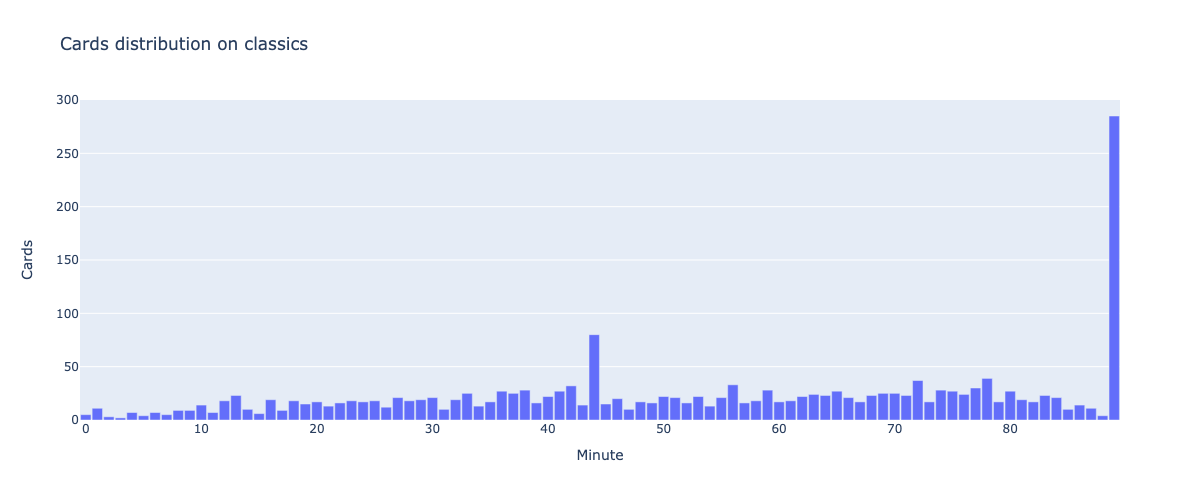

In [11]:
fig = go.Figure(data=[go.Bar(x=list(range(len(cards_time_on_classics))), y=cards_time_on_classics)])

fig.update_layout(
    title='Cards distribution on classics',
    xaxis_title='Minute',
    yaxis_title='Cards',
    bargap=0.1
)

fig.show('png', width=1200)

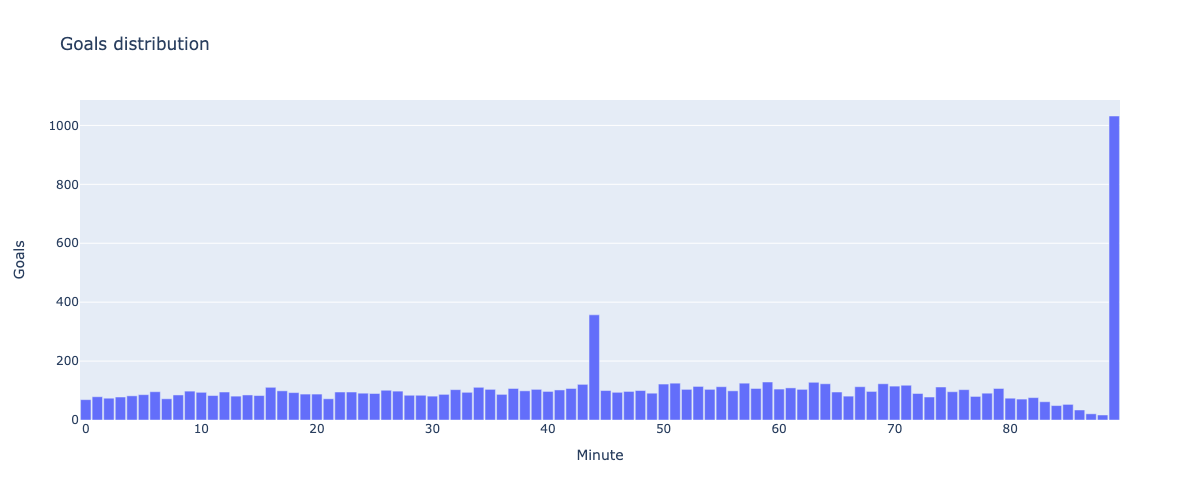

In [12]:
fig = go.Figure(data=[go.Bar(x=list(range(len(goals_time))), y=goals_time)])

fig.update_layout(
    title='Goals distribution',
    xaxis_title='Minute',
    yaxis_title='Goals',
    bargap=0.1
)

fig.show('png', width=1200)

In [13]:
summary = dict()
for file in sorted(glob('../../Data/results/processed/Serie_A_*_squads.json')):
    season = int(file[-16:-12])
    if season == 2024: continue
    info_file = file.replace('squads', 'games')
    with open(file, 'rb') as f: data = json.load(f)
    with open(info_file, 'rb') as f: info = json.load(f)
    for game in data:
        home_club = info[game]['Home']
        away_club = info[game]['Away']
        if home_club not in summary: summary[home_club] = dict()
        if away_club not in summary: summary[away_club] = dict()
        if season not in summary[home_club]: summary[home_club][season] = set()
        if season not in summary[away_club]: summary[away_club][season] = set()
        for sub_game in data[game]:
            home_squad = set(data[game][sub_game]['Home']['Squad'])
            away_squad = set(data[game][sub_game]['Away']['Squad'])
            summary[home_club][season] = summary[home_club][season].union(home_squad)
            summary[away_club][season] = summary[away_club][season].union(away_squad)

for club in summary:
    for season in summary[club]:
        summary[club][season] = len(summary[club][season])
    
    summary[club] = sum(summary[club].values()) / len(summary[club])

summary

{'Vasco da Gama / RJ': 39.42857142857143,
 'Portuguesa / SP': 38.0,
 'Fluminense / RJ': 36.36363636363637,
 'Athletico Paranaense / PR': 36.63636363636363,
 'Corinthians / SP': 34.18181818181818,
 'Botafogo / RJ': 37.666666666666664,
 'Vitória / BA': 40.0,
 'Internacional / RS': 37.7,
 'Grêmio / RS': 38.6,
 'Náutico / PE': 41.0,
 'Ponte Preta / SP': 39.25,
 'São Paulo / SP': 35.27272727272727,
 'Criciúma / SC': 46.0,
 'Bahia / BA': 35.375,
 'Cruzeiro / MG': 36.25,
 'Goiás / GO': 38.714285714285715,
 'Coritiba / PR': 41.875,
 'Atlético Mineiro / MG': 34.63636363636363,
 'Santos / SP': 38.18181818181818,
 'Flamengo / RJ': 35.81818181818182,
 'Figueirense / SC': 39.666666666666664,
 'Sport / PE': 33.857142857142854,
 'Palmeiras / SP': 36.6,
 'Chapecoense / SC': 37.142857142857146,
 'Joinville / SC': 46.0,
 'Avaí / SC': 38.0,
 'Santa Cruz / PE': 41.0,
 'América / MG': 39.8,
 'Atlético / GO': 32.75,
 'Paraná / PR': 50.0,
 'Ceará / CE': 37.2,
 'CSA / AL': 40.0,
 'Fortaleza / CE': 31.2,
 'Red